In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [5]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

## 1. Подготовка данных и тщательный анализ

Посмотрим на распределение целевой переменной

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


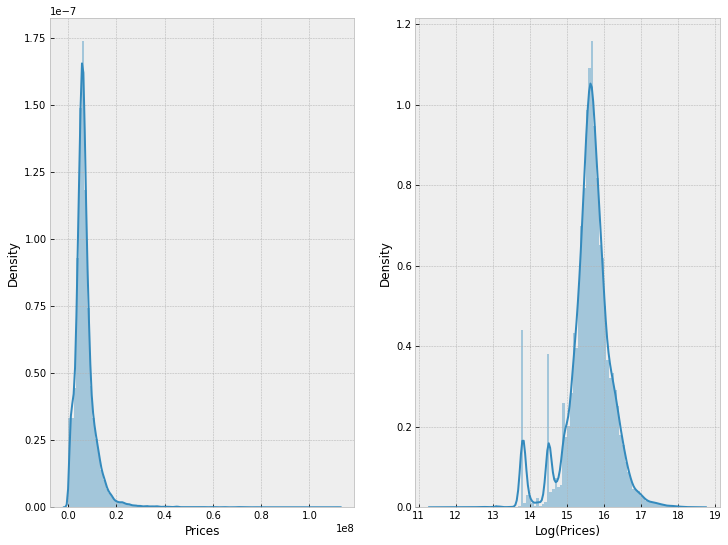

In [6]:
with plt.style.context('bmh'): 
    fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize = (12,9))
    sns.distplot(train['price_doc'], bins=100, ax = ax1)
    sns.distplot(np.log(train['price_doc'].values), bins=100, ax = ax2)
    ax1.set_xlabel("Prices")
    ax2.set_xlabel("Log(Prices)")
    plt.show()

In [7]:
train['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

In [8]:
corr_with_prices=train.corr(method='pearson').iloc[-int(1)][:-int(1)]

pd.DataFrame(corr_with_prices[abs(corr_with_prices).argsort()[::-int(1)]])

,price_doc
num_room,0.476337
full_sq,0.341840
sport_count_5000,0.294864
sport_count_3000,0.290651
trc_count_5000,0.289371
...,...
cafe_sum_3000_min_price_avg,0.005119
cafe_avg_price_3000,0.003339
cafe_sum_3000_max_price_avg,0.002200
build_year,0.002161


In [9]:
features_list=corr_with_prices[abs(corr_with_prices).argsort()[::-int(1)]][:int(10)].index.values.tolist()
print('Наиболее коррелируемые признаки:\n'); features_list

Наиболее коррелируемые признаки:



['num_room',
 'full_sq',
 'sport_count_5000',
 'sport_count_3000',
 'trc_count_5000',
 'zd_vokzaly_avto_km',
 'sadovoe_km',
 'kremlin_km',
 'bulvar_ring_km',
 'sport_count_2000']

Посмотрим на пропущенные данные

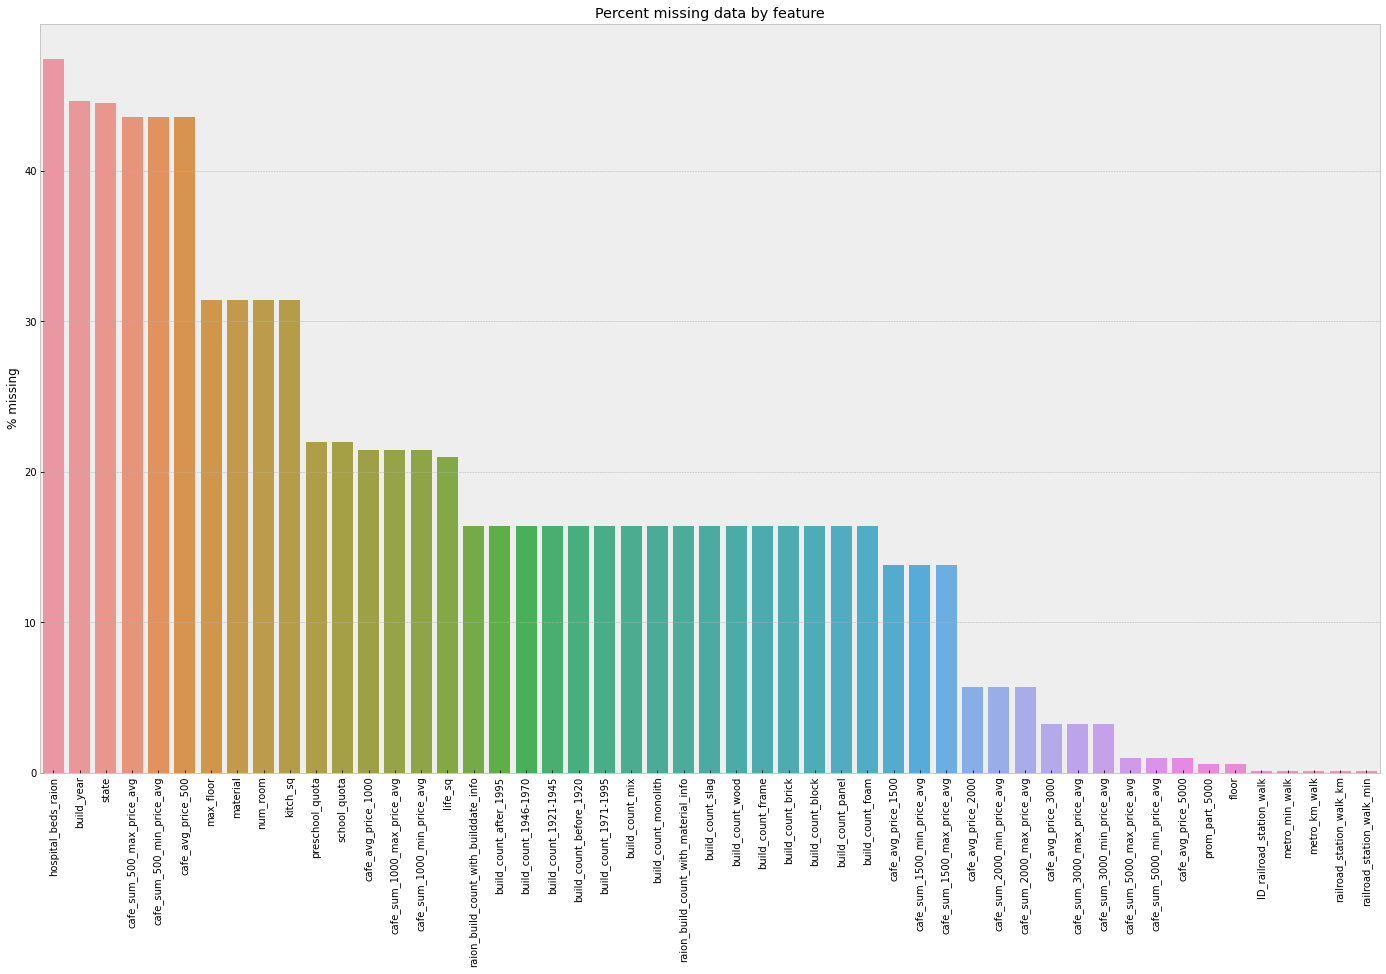

In [10]:
with plt.style.context('bmh'): 
    train_na = (train.isnull().sum() / len(train)) * 100
    train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(24, 16))
    plt.xticks(rotation='90')
    sns.barplot(x=train_na.index, y=train_na)
    ax.set(title='Percent missing data by feature', ylabel='% missing')
    plt.subplots_adjust(top = 0.95, bottom = 0.3)
    plt.show()

Посмотрим на распределения некоторых важных признаков.

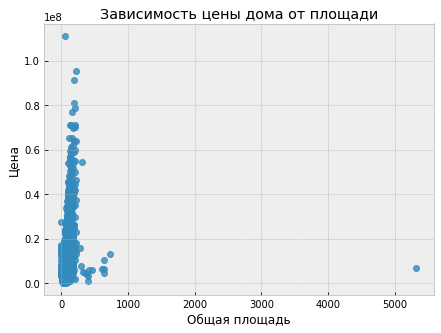

In [11]:
# Цена и общая площадь
with plt.style.context('bmh'): 
    fig, ax = plt.subplots(figsize = (7,5))
    sns.regplot(x = 'full_sq', y = 'price_doc', data = train, fit_reg = False)
    ax.set_title('Зависимость цены дома от площади')
    ax.set_xlabel('Общая площадь')
    ax.set_ylabel('Цена')
    plt.show()

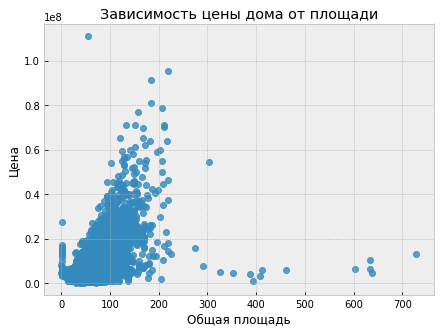

In [12]:
# То же самое, удалив выбросы
with plt.style.context('bmh'):
    fig, ax = plt.subplots(figsize = (7,5))
    sns.regplot(x = 'full_sq', y = 'price_doc', data = train[train['full_sq'] < 1000]  , fit_reg = False)
    ax.set_title('Зависимость цены дома от площади')
    ax.set_xlabel('Общая площадь')
    ax.set_ylabel('Цена')
    plt.show()

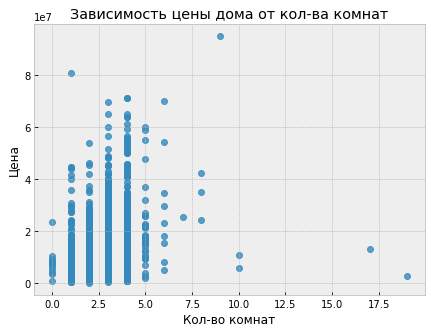

In [13]:
# Scatterplot vs. Number of Rooms:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(figsize = (7,5))
    sns.regplot(x = 'num_room', y = 'price_doc', data = train, fit_reg = False)
    ax.set_title('Зависимость цены дома от кол-ва комнат')
    ax.set_xlabel('Кол-во комнат')
    ax.set_ylabel('Цена')
    plt.show()

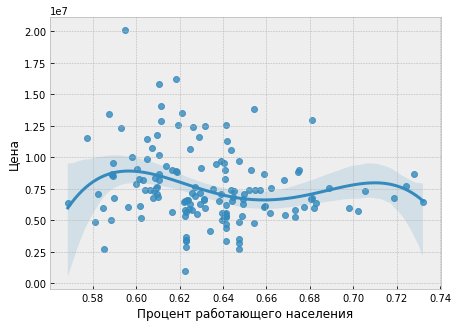

In [14]:
# Определим признак work_share как процент работающего населения. Визуализируем распределение признака.
train['work_share'] = train['work_all']/train['raion_popul']
train_workshrgrp = train.groupby('sub_area')[['work_share', 'price_doc']].mean()


with plt.style.context('bmh'):
    fig, ax = plt.subplots(figsize = (7,5))
    sns.regplot(x = 'work_share', y = 'price_doc', data = train_workshrgrp, order = 4, ci = 95)
    ax.set_xlabel('Процент работающего населения')
    ax.set_ylabel('Цена')
    plt.show()

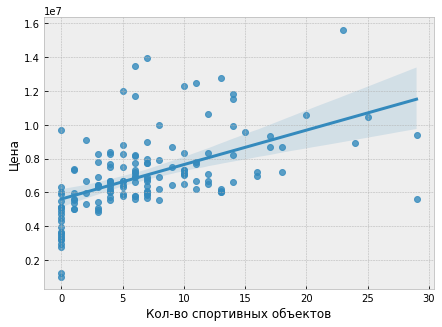

In [15]:
# Определим признак sport_objects_raion как кол-во спортивных объектов. Визуализируем распределение признака.
train_sportsgrp = train.groupby('sub_area')[['sport_objects_raion', 'price_doc']].median()

with plt.style.context('bmh'):
    fig, ax = plt.subplots(figsize = (7,5))
    sns.regplot(x = 'sport_objects_raion', y = 'price_doc', data = train_sportsgrp, ci = 95)
    ax.set_xlabel('Кол-во спортивных объектов')
    ax.set_ylabel('Цена')
    plt.show()

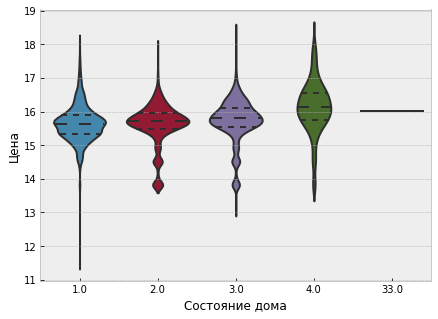

In [16]:
# Зависимость цены дома от его состояние (обратите внимание на выброс, который нужно заменить на "3")
train['price_doc_log'] = np.log1p(train['price_doc'])

with plt.style.context('bmh'):
    fig, ax = plt.subplots(figsize = (7,5))
    sns.violinplot(x = 'state', y = 'price_doc_log', data = train, inner='quartile')
    ax.set_xlabel('Состояние дома')
    ax.set_ylabel('Цена')
    plt.show()

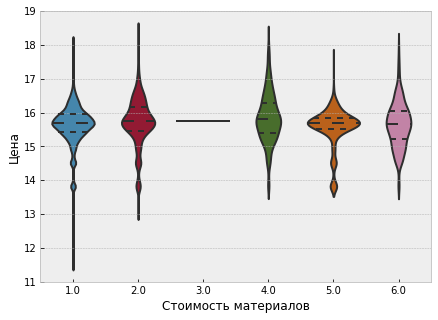

In [17]:
# Зависимость цены дома от его стоимости материалов (снова обращаем внимание на выброс)
with plt.style.context('bmh'):
    fig, ax = plt.subplots(figsize = (7,5))
    sns.violinplot(x = 'material', y = 'price_doc_log', data = train, inner='quartile')
    ax.set_xlabel('Стоимость материалов')
    ax.set_ylabel('Цена')
    plt.show()

Добавим новые признаки

In [18]:
train_price = train[['id', 'price_doc']].copy()
train.drop('price_doc', axis = 1, inplace = True)
len(train.columns)

# Соединим тестовую и обучающую выборки
all_data = pd.concat([train, test])
all_data.shape

(38133, 293)

In [19]:
# Удалим признаки, которые практически не имеют отличий
zero_variance = ["culture_objects_top_25_raion", "oil_chemistry_raion", "railroad_terminal_raion", "nuclear_reactor_raion",
                 "build_count_foam", "big_road1_1line", "railroad_1line", "office_sqm_500", "trc_sqm_500",
                 "cafe_count_500_price_4000", "cafe_count_500_price_high", "mosque_count_500", "leisure_count_500",
                 "office_sqm_1000", "trc_sqm_1000", "cafe_count_1000_price_high", "mosque_count_1000", "cafe_count_1500_price_high",
                 "mosque_count_1500", "cafe_count_2000_price_high"]

# Не нужные признаки с ID
useless_ids = ["ID_metro", "ID_railroad_station_walk", "ID_railroad_station_avto", "ID_big_road1", "ID_big_road2",
               "ID_railroad_terminal", "ID_bus_terminal"]

In [20]:
all_data.drop(zero_variance + useless_ids, axis = 1, inplace = True)
all_data.shape

(38133, 266)

In [21]:
print(all_data['state'].value_counts())
all_data['state'].replace(to_replace = 33, value = 3, inplace = True)

2.0     8506
3.0     7703
1.0     7121
4.0      549
33.0       1
Name: state, dtype: int64


In [22]:
print(all_data['build_year'].value_counts())
bld_yr_replace = {20052009:2005, 0:np.nan, 1:np.nan, 2:np.nan, 3:np.nan, 20:2000, 215:2015, 4965:1965, 71:1971}
all_data['build_year'].replace(to_replace = bld_yr_replace, inplace = True)

2014.0    1118
2015.0    1083
0.0        899
2016.0     775
2013.0     724
          ... 
1886.0       1
1925.0       1
1691.0       1
20.0         1
1898.0       1
Name: build_year, Length: 127, dtype: int64


In [23]:
print(all_data['material'].value_counts())
all_data['material'].replace(to_replace = 3, value = 1, inplace = True)

1.0    19438
2.0     3951
5.0     2048
4.0     1963
6.0     1159
3.0        2
Name: material, dtype: int64


In [24]:
print(all_data['full_sq'].describe())
all_data['full_sq'].replace(to_replace = 0, value = np.nan, inplace = True)

count    38133.000000
mean        54.111172
std         35.171162
min          0.000000
25%         38.900000
50%         50.000000
75%         63.000000
max       5326.000000
Name: full_sq, dtype: float64


In [25]:
print(all_data['num_room'].describe())
all_data['num_room'].replace(to_replace = 0, value = np.nan, inplace = True)

count    28561.000000
mean         1.900844
std          0.847620
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: num_room, dtype: float64


In [26]:
print(all_data['max_floor'].describe())
max_flr_replace = {117:17, 99:np.nan, 0:np.nan}
all_data['max_floor'].replace(to_replace = max_flr_replace, inplace = True)

count    28561.000000
mean        12.567592
std          6.730496
min          0.000000
25%          9.000000
50%         12.000000
75%         17.000000
max        117.000000
Name: max_floor, dtype: float64


In [27]:
# Дополнительные признаки для времени
all_data['year'] = all_data['timestamp'].apply(lambda x: int(x[0:4]))
all_data['year_mo'] = all_data['timestamp'].apply(lambda x: x[0:7])

# Признак возраста дома
all_data['years_old'] = 2022 - all_data['build_year']

# Отношение жилой площади и площади кухни к общей площади
all_data['resident_to_total_ratio'] = all_data['life_sq']/all_data['full_sq']
all_data['kitchen_to_total_ratio'] = all_data['kitch_sq']/all_data['full_sq']

# Средняя площадь комнаты
all_data['avg_room_area'] = all_data['life_sq']/all_data['num_room']

# Дополнительная площадь
all_data['extra_area'] = all_data['full_sq'] - all_data['life_sq']
all_data['extra_area_ratio'] = all_data['extra_area']/all_data['full_sq']

# Процент работающего населения
all_data['pct_labor_force'] = all_data['work_all']/all_data['raion_popul']

# Количество пропусков в каждом столбце
all_data['count_nan_per_row'] = all_data.isnull().sum(axis = 1)

all_data['full_sq_floored'] = all_data['full_sq'].apply(lambda x: max(x, 50))

In [28]:
print(all_data.shape)

# Исключим объекты, которые есть в test, но нет в train
train_fe = all_data[all_data['id'].isin(train_price['id'])]
train_fe = pd.merge(train_fe, train_price, on = ['id'], how = 'inner')
print(train_fe.shape)

test_fe = all_data[~all_data['id'].isin(train_price['id'])]
test_fe.shape

(38133, 277)
(30471, 278)


(7662, 277)

In [29]:
# Исключим слишком большие и слишком маленькие цены за квадратный метр
train_fe = train_fe[train_fe.price_doc/train_fe.full_sq_floored <= 600000]
train_fe = train_fe[train_fe.price_doc/train_fe.full_sq_floored >= 10000]
train_fe.shape

(30428, 278)

In [30]:
# Зафиксируем целевую переменную
train_fe['price_doc'] = train_fe['price_doc'].apply(lambda x: np.log1p(x))
train_fe['price_doc'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    30428.000000
mean        15.612321
std          0.598456
min         13.122365
25%         15.372747
50%         15.653772
75%         15.931766
max         18.370676
Name: price_doc, dtype: float64

In [31]:
# Подготовим данные к XGB
test_id = test_fe['id'].copy()
train_target = train_fe['price_doc'].copy()
train_fe.drop(['id', 'timestamp', 'price_doc'], axis = 1, inplace = True)
test_fe.drop(['id', 'timestamp'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
# Категориальные и числовые признаки
train_fe_num = train_fe.select_dtypes(exclude=['object'])
train_fe_cat = train_fe.select_dtypes(include=['object']).copy()
test_fe_num = test_fe.select_dtypes(exclude=['object'])
test_fe_cat = test_fe.select_dtypes(include=['object']).copy()

for cat in train_fe_cat:
    train_fe_cat[cat] = pd.factorize(train_fe_cat[cat])[0]
for cat in test_fe_cat:
    test_fe_cat[cat] = pd.factorize(test_fe_cat[cat])[0]

train_fe = pd.concat([train_fe_num, train_fe_cat], axis=1)
test_fe = pd.concat([test_fe_num, test_fe_cat], axis=1)

# Создаем матрицу XGB
print(train_fe.shape, test_fe.shape)
train_DMat = xgb.DMatrix(train_fe.values, train_target.values, feature_names = train_fe.columns)
test_DMat = xgb.DMatrix(test_fe.values, feature_names = test_fe.columns)

(30428, 275) (7662, 275)


## 2. Выбор алгоритма и его гиперпараметров.

XGBoost — алгоритм машинного обучения, основанный на дереве поиска решений и использующий фреймворк градиентного бустинга. В задачах предсказания, которые используют неструктурированные данные (например, изображения или текст), искусственная нейронная сеть превосходит все остальные алгоритмы или фреймворки.

[17:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


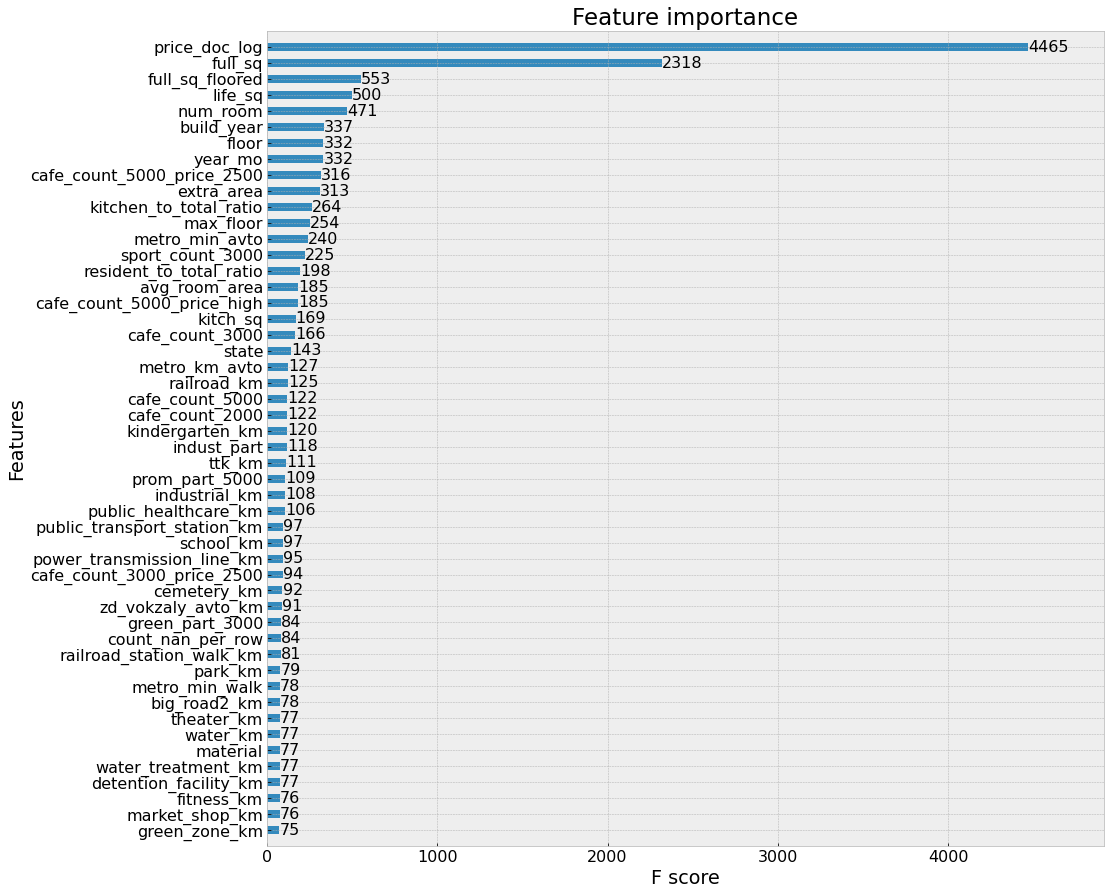

In [55]:
xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    "min_child_weight": 1,
    "gamma": 0,
    "alpha": 0,
    "nthread": 8
}

test_model = xgb.train(params = xgb_params, dtrain = train_DMat, num_boost_round = 750)
test_model.best_iteration

# Финальный анализ
with plt.style.context('bmh'):
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    xgb.plot_importance(test_model, max_num_features = 50, height = 0.5, ax = ax)
    plt.show()

In [57]:
price_pred_log = test_model.predict(test_DMat)
price_pred = np.exp(price_pred_log) - 1

xgb_sub1 = pd.DataFrame({'id':test_id, 'price_doc':price_pred})
xgb_sub1.to_csv("xgb_sub.csv", index = False)

In [61]:
xgb_sub1.head()

,id,price_doc
0,30474,541900.1250
1,30475,788745.5000
2,30476,556576.0625
3,30477,743762.0625
4,30478,564782.5000
